<a href="https://colab.research.google.com/github/prabhatn99/azure4everyone-samples/blob/master/Task_Agnostic_DCP_Colab_Node_js_Mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Mandelbrot Set with DCP
Last upated: July 28, 2021

The Mandelbrot set is a special set of complex numbers that gained popularity because of the beautiful fractal images it produces. You can find many videos online of infinite Mandelbrot zooms with lively colours. This Colab will take you through the steps of creating your own Mandelbrot zoom on DCP. 

With **DCP**, computers and devices in classrooms, computer labs, households, and enterprises can be turned into computing clusters with a single click to accelerate the zoom creation. The entire creation of the gif, called a **job**, will be sub-divided into smaller parts, called **slices**, that are executed in paralled using **DCP**. Each slice corresponds to a specified number of frames of the zoom.

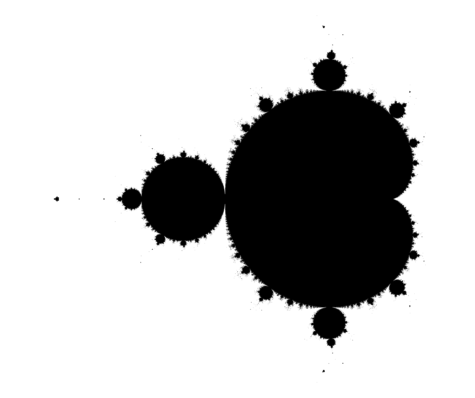

# DCP Overview

**Summary**

---

DCP is intended to be an easy-to-use, powerful parallel computing framework that allows users to express a computational **job** as easily as:

`job = compute.for(inputSet, workFunction)`

`resultSet = await job.exec()`

where a `workFunction` is maped onto each element in an `inputSet`. Each maping represents a **slice**. Slices are automatically distributed across DCP networks for computation, and results are automatically returned to the user in the correct order. Said otherwise, imagine writing a parallel *for loop* in which loop elements are independently calculated (no recursion), but instead of executing that loop with your laptop, you're simultaneously executing it with hundreds or thousands of laptops, computers, servers.

DCP also allows users to create their own computing networks with arbitrary computers and devices. **Public** DCP network: earn compute Credits when executing work, spend Credits when deploying work (sharing economy). **Private** DCP networks: create your own network with computers and devices lying around and use it as much as you want (contact us to get private compute group credentials).

**DCP Workflow**

---

1. Create compute nodes: go to https://dcp.work on as many devices as you want and click `Start` to join the public compute group, or to `dcp.work/<joinKey>` if you have a private compute group `joinKey` and `joinSecret`.
2. Configure dev environment: load `dcp-client` and any required packages.
3. Specify the `inputSet`: an arbitrary, but enumerable input dataset (parameters, mp3 files, images, blender project file, etc)
4. Specify the `workFunction`: an arbitrary work function (physics simulation, inference model, rendering process, etc)
5. Express the `job`: Map the workFunction onto the inputSet with `job = compute.for(inputSet, workFunction)`
6. (optional) Specify a compute group with `job.computeGroups=[{joinKey: '<name>', joinSecret: '<password>'}]`
7. Await the `resultSet`: Execute the job in parallel on DCP via `resultSet = await job.exec()`

In the example that follows, DCP is used to perform a distributed hyperparameter search using the MNIST dataset. While this example uses Google Colab, you can also perform the same workflow in your preferred development environment or via a web application.

# The Mandelbrot Set Overview

The Mandelbrot set is the set of complex numbers c for which the following function, $f_c(z) = z^2 + c$ does not diverge when iterated from z = 0. 

We see two cases with this function,
1. The value gets arbitarily large
2. The value is bounded by 2

Lets look at examples of both of these cases.

1. c = 1

    $f_1(0) = 0^2 + 1 = 1$

    $f_1(1) = 1^2 + 1 = 2$

    $f_1(2) = 2^2 + 1 = 5$

    $f_1(5) = 5^2 + 1 = 26$

We see here that the values blow up past 2 and so c = 1 is **not** in the Mandelbrot set.

2. c = -1 

    $f_{-1}(0) = 0^2 + (-1) = -1$

    $f_{-1}(-1) = -1^2 + (-1) = 0$

    $f_{-1}(0) = 0^2 + (-1) = -1$

    $f_{-1}(-1) = -1^2 + (-1) = 0$

   We can see this will continue to repeat and will never blow up past 2, so c = -1 is in the Mandelbrot set.

Now that we've understood what the Mandelbrot set is, lets go over how we will create our own Mandelbrot zoom.


# How will we do this?
Now that we have an understanding of what the Mandelbrot set is we can get a clear understanding of how this will be coded. We'll want to establish a canvas and take each point in that canvas and run in through the function $f_c(z)$ until it goes toward infinity or we reach a maximum number of iterations without it going passed 2. We then want to plot the colour of each point depending on which category that point falls into. That will create one frame, to create the zoom we will continuously develop a new canvas which will be moving closer to a specified point. 

# Configure Node.js and DCP environment
`node.js`, `dcp-client`, and any repositories and libraries required by your workload will be installed. You will also require a DCP API key available from https://portal.distributed.computer

## Node.js

This example uses `bifrost`, a tool that provides a custom `Node.js` backend with the ability to convert Python variables to JavaScript variables for use in the Node environment.

In [24]:
# Downloads and installs a customized Node.js backend for this notebook
# This may take a few moments when first executed in a new runtime

!npm install --quiet -g n && n 10.20.1
!pip install --quiet git+https://github.com/Kings-Distributed-Systems/Bifrost@interface

from bifrost import node, npm, dcp_deploy, dcp_install

/usr/local/bin/n -> /usr/local/lib/node_modules/n/bin/n
+ n@7.3.1
added 1 package from 2 contributors in 0.258s
   installed : v10.20.1 (with npm 6.14.4)


## DCP client

With `Node.js` configured, install the `dcp-client` library:


In [25]:
dcp_install()

True

## DCP API key

An API key containing compute Credits, called a DCP Bank Account keystore, is required to launch a compute job on DCP. Earn compute Credits by executing workloads from the public DCP network (sharing compute economy), or purchase them if you do not wish to contribute computing power to the public network. Obtain your keystore from https://portal.distributed.computer

In [26]:
# Loads a DCP Account keystore containing compute Credits
# When prompted, please upload your keystore file

from google.colab import files

KEYSTORE_NAME = list(files.upload().keys())[0]

!mkdir -p ~/.dcp
!cp /content/$KEYSTORE_NAME ~/.dcp/default.keystore
!cp /content/$KEYSTORE_NAME ~/.dcp/id.keystore

Saving default.keystore to default (2).keystore


## Upload Custom Node.JS Scripts

In [27]:
# put your package dependency name(s) here, in the form 'YOUR_DEPENDENCY' (taken from your package.json)

npm.install('sharp')
npm.install('png-file-stream')
npm.install('gifencoder')


> sharp@0.28.3 install /content/node_modules/sharp
> (node install/libvips && node install/dll-copy && prebuild-install) || (node install/can-compile && node-gyp rebuild && node install/dll-copy)

sharp: Using cached /root/.npm/_libvips/libvips-8.10.6-linux-x64.tar.br
+ sharp@0.28.3
updated 1 package and audited 493 packages in 4.225s

35 packages are looking for funding
run `npm fund` for details

found 2 vulnerabilities (1 moderate, 1 high)
run `npm audit fix` to fix them, or `npm audit` for details
+ png-file-stream@1.2.1
updated 1 package and audited 493 packages in 3.355s

38 packages are looking for funding
run `npm fund` for details

found 2 vulnerabilities (1 moderate, 1 high)
run `npm audit fix` to fix them, or `npm audit` for details
+ gifencoder@2.0.1
updated 1 package and audited 493 packages in 3.123s

38 packages are looking for funding
run `npm fund` for details

found 2 vulnerabilities (1 moderate, 1 high)
run `npm audit fix` to fix them, or `npm audit` for details


In [28]:
# Import custom scripts

from google.colab import files

!mkdir -p /content/mandelbrot_images
FILE_NAMES = list(files.upload().keys())

Saving image-animation.js to image-animation (3).js
Saving main.js to main (3).js
Saving mandelbrot-set.js to mandelbrot-set (4).js


In [29]:
%%node

main = require("/content/main.js");
mandelbrot = require("/content/mandelbrot-set.js");
animation = require("/content/image-animation.js");

In [30]:
%%node

frames_num = 10;
frames_per_worker = 2;

canvas_size = {
    height: 400,
    width: 600
}

z0 = { re: 0.42884, im: -0.231345 };
speed = 0.4;

max_iterations = 1000;

In [31]:
%%node

input_set = main.get_pre_frames(frames_num, canvas_size, z0, speed);

In [32]:
%%node

main.dcp_function(
    input_set, frames_per_worker, canvas_size, max_iterations
).then((result) => { result_set = result });

new ready state: exec
new ready state: init
new ready state: preauth
new ready state: deploying
new ready state: listeners
new ready state: deployed
- Job accepted by scheduler, waiting for results
- Job has id 0x84905ec9b422Ea4C11488173EEF087ECC1739D4C
Got status update:  { runStatus: 'estimation',
total: 10,
distributed: 0,
computed: 0 }
- Received result for slice 1 at 8.5s
Got status update:  { runStatus: 'estimation',
total: 10,
distributed: 10,
computed: 1 }
Got status update:  { runStatus: 'estimation',
total: 10,
distributed: 10,
computed: 2 }
- Received result for slice 10 at 11.1s
Got status update:  { runStatus: 'running', total: 10, distributed: 10, computed: 3 }
- Received result for slice 9 at 13.3s
Got status update:  { runStatus: 'running', total: 10, distributed: 10, computed: 4 }
- Received result for slice 2 at 15.7s
- Received result for slice 8 at 18.6s
Got status update:  { runStatus: 'running', total: 10, distributed: 10, computed: 5 }
Got status update:  { runSt

In [33]:
%%node

main.image_function(
    result_set,
    frames_per_worker,
    canvas_size
);

In [34]:
%%node

// # setup for dcp_deploy
/*
#work_function = main.build_worker_string();
#
#work_parameters = [canvas_size, max_iterations, frames_per_worker];
*/

In [35]:
#dcp_deploy(input_set, work_function, work_parameters)

**Our Output**

---

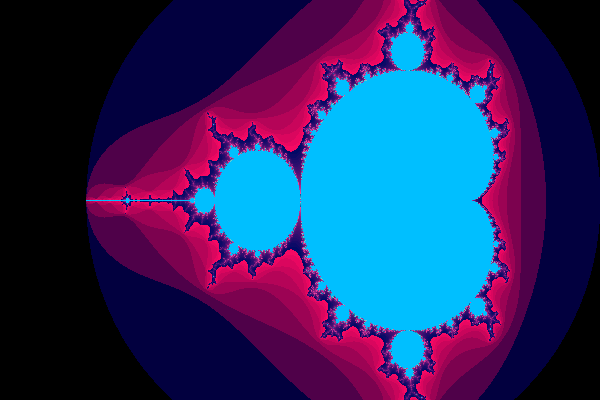

#Thank you!

We hope you enjoyed that demo, and are now imagining all kinds of distributable workloads, like numerical simulations, rendering, inference, blockchain, compilation, OCR, and more!

We are just getting started with **DCP** so if you have cool suggestions, features, or want to help build, get in touch!

Manage your Compute Credits at https://portal.distributed.computer

Slack us in our `#dev-connection` channel: https://join.slack.com/t/dcp-devs/shared_invite/zt-56v87qj7-fkqZOXFUls8rNzO4mxHaIA

Write to us: info@distributed.computer